<a href="https://colab.research.google.com/github/A-Istrate/80629_Project/blob/main/ML_TPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
from PIL import Image
import PIL.Image
import tensorflow as tf
import pathlib
import os
import re
import gc
import sklearn
from tensorflow.keras import layers
from sklearn.utils import class_weight

Checking our images

In [8]:
gc.collect()

37

In [120]:
## images path
path_s = r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final"
path = pathlib.Path(path_s)
image_count=len(list(path.glob('*/*/*.jpg')))
print(image_count)

43325


In [121]:
### Train Validation TEST and survey
path_train = pathlib.Path(r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\train")
path_valid = pathlib.Path(r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\valid")
path_test = pathlib.Path(r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\test")
path_survey = pathlib.Path(r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers_final\survey")


Checking a childrens book

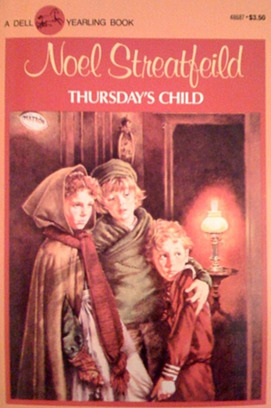

In [122]:
children = list(path.glob('./train/Childrens/*'))
PIL.Image.open(str(children[12]))

Creating a dataset

In [12]:
## Image parameters
batch_size =32
img_height = 150
img_width =100

In [123]:
## train
list_train = tf.data.Dataset.list_files(str(str(path_train)+"\*/*.jp*"),shuffle=False)
list_train = list_train.shuffle(len(list_train),reshuffle_each_iteration=False)
## valid
list_valid = tf.data.Dataset.list_files(str(str(path_valid)+"\*/*.jp*"),shuffle=False)
list_valid = list_valid.shuffle(len(list_valid),reshuffle_each_iteration=False)
## test
list_test = tf.data.Dataset.list_files(str(str(path_test)+"\*/*.jp*"),shuffle=False)
list_test = list_test.shuffle(len(list_test),reshuffle_each_iteration=False)
## survey
list_survey = tf.data.Dataset.list_files(str(str(path_survey)+"\*.jp*"),shuffle=False)
list_survey = list_survey.shuffle(len(list_survey),reshuffle_each_iteration=False)

In [126]:
a = [str(o.numpy()).rsplit("\\")[-1] for o in list_train]
b = [str(o.numpy()).rsplit("\\")[-1]  for o in list_valid]
c = [str(o.numpy()).rsplit("\\")[-1]  for o in list_test]

In [127]:
len(set(a).intersection(b))

0

In [128]:
len(set(a).intersection(c))

0

In [131]:
len(set(c).intersection(b))

0

In [132]:
for f in list_train.take(5):
  print(f.numpy())

b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers_final\\train\\Mystery & Crime\\15445.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers_final\\train\\Poetry\\50898.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers_final\\train\\Mystery & Crime\\7343.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers_final\\train\\Young Adult\\1133.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers_final\\train\\Romance\\5382.jpg'


In [133]:
# getting the classes names
class_names = np.array(sorted([item.name for item in path_train.glob('*') if os.path.isdir(item)]))
print(class_names)

['Biography' 'Childrens' 'Fantasy' 'Historical' 'Horror' 'Mystery & Crime'
 'Poetry' 'Politics & History' 'Religion & Philosophy' 'Romance'
 'Science Fiction' 'Sequential Art' 'Young Adult']


In [134]:
## Number of items in each sample
print(tf.data.experimental.cardinality(list_train).numpy())
print(tf.data.experimental.cardinality(list_valid).numpy())
print(tf.data.experimental.cardinality(list_test).numpy())
print(tf.data.experimental.cardinality(list_survey).numpy())

31653
7926
3746
65


In [17]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  
  return tf.argmax(one_hot)

In [18]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [19]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
         
    return img,label


In [135]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = list_train.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = list_valid.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = list_test.map(process_path, num_parallel_calls=AUTOTUNE)
survey_ds = list_survey.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (150, 100, 3)
Label:  Mystery & Crime


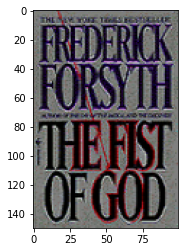

In [136]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", class_names[label.numpy()])
  plt.imshow(image.numpy().astype("uint8"))

Image augmentation

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])


In [138]:
def configure_for_performance_train(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000,reshuffle_each_iteration=True)
  #print(ds)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def configure_for_performance_other(ds):
  ds = ds.cache()
  # ds = ds.shuffle(buffer_size=1000,reshuffle_each_iteration=False)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance_train(train_ds)
val_ds = configure_for_performance_other(val_ds)
test_ds = configure_for_performance_other(test_ds)
survey_ds = configure_for_performance_other(survey_ds)

In [24]:
gc.collect()

2674

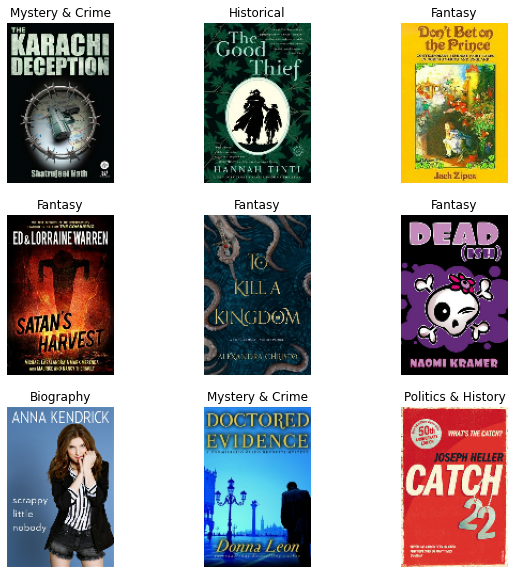

In [139]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Classes

In [29]:
num_classes=13

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,padding='same',strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,padding='same',strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,padding='same',strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(
   
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
        epsilon=0.01
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [30]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
990/990 [==============================] - 149s 149ms/step - loss: 2.3879 - accuracy: 0.1922 - val_loss: 2.3022 - val_accuracy: 0.2227
Epoch 2/50
990/990 [==============================] - 138s 139ms/step - loss: 2.3152 - accuracy: 0.2129 - val_loss: 2.3099 - val_accuracy: 0.2203
Epoch 3/50
990/990 [==============================] - 136s 137ms/step - loss: 2.3078 - accuracy: 0.2194 - val_loss: 2.2572 - val_accuracy: 0.2370
Epoch 4/50
990/990 [==============================] - 134s 136ms/step - loss: 2.2773 - accuracy: 0.2326 - val_loss: 2.2322 - val_accuracy: 0.2357
Epoch 5/50
990/990 [==============================] - 139s 140ms/step - loss: 2.2447 - accuracy: 0.2355 - val_loss: 2.1555 - val_accuracy: 0.2686
Epoch 6/50
990/990 [==============================] - 136s 138ms/step - loss: 2.2124 - accuracy: 0.2505 - val_loss: 2.1332 - val_accuracy: 0.2826
Epoch 7/50
990/990 [==============================] - 140s 141ms/step - loss: 2.1692 - accuracy: 0.2646 - val_loss: 2.0513 -

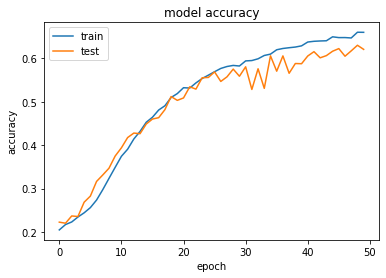

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
model.save("model_ns.h5")

In [52]:
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

In [53]:
vclasses = list()
vclasses = [[c.numpy() for c in object[1]]for object in test_ds]

In [54]:
validation_classes = np.concatenate(vclasses).ravel()

In [58]:
[[class_names[a],class_names[b]] for a,b in zip(predicted_classes,validation_classes)][0:30]

[['Young Adult', 'Young Adult'],
 ['Fantasy', 'Fantasy'],
 ['Horror', 'Poetry'],
 ['Fantasy', 'Mystery & Crime'],
 ['Fantasy', 'Fantasy'],
 ['Science Fiction', 'Politics & History'],
 ['Sequential Art', 'Sequential Art'],
 ['Young Adult', 'Young Adult'],
 ['Horror', 'Horror'],
 ['Fantasy', 'Fantasy'],
 ['Historical', 'Horror'],
 ['Young Adult', 'Young Adult'],
 ['Young Adult', 'Fantasy'],
 ['Fantasy', 'Fantasy'],
 ['Fantasy', 'Fantasy'],
 ['Fantasy', 'Biography'],
 ['Fantasy', 'Horror'],
 ['Historical', 'Poetry'],
 ['Fantasy', 'Fantasy'],
 ['Fantasy', 'Young Adult'],
 ['Fantasy', 'Fantasy'],
 ['Historical', 'Romance'],
 ['Politics & History', 'Politics & History'],
 ['Childrens', 'Childrens'],
 ['Romance', 'Romance'],
 ['Romance', 'Religion & Philosophy'],
 ['Politics & History', 'Politics & History'],
 ['Mystery & Crime', 'Mystery & Crime'],
 ['Religion & Philosophy', 'Religion & Philosophy'],
 ['Religion & Philosophy', 'Politics & History']]

In [56]:
from sklearn.metrics import classification_report
print(classification_report(validation_classes, predicted_classes, target_names=class_names))

                       precision    recall  f1-score   support

            Biography       0.66      0.48      0.56       171
            Childrens       0.69      0.46      0.55       139
              Fantasy       0.58      0.78      0.67       749
           Historical       0.58      0.58      0.58       381
               Horror       0.81      0.50      0.62       113
      Mystery & Crime       0.67      0.62      0.64       340
               Poetry       0.78      0.38      0.51        96
   Politics & History       0.64      0.47      0.55       190
Religion & Philosophy       0.52      0.51      0.51       263
              Romance       0.54      0.69      0.61       560
      Science Fiction       0.73      0.50      0.59       222
       Sequential Art       0.79      0.66      0.72       136
          Young Adult       0.70      0.60      0.65       389

             accuracy                           0.61      3749
            macro avg       0.67      0.56      0.60 

In [37]:
def prediction_score(valid,predictions,cnames=class_names):
    pred = np.argmax(predictions, axis=1)
    pred2 = np.argsort(predictions,axis=1)[:,-2]
    pred3 = np.argsort(predictions,axis=1)[:,-3]
    dict_c = dict(enumerate(cnames))
    scores=[]
    for v,p1,p2,p3 in zip(valid,pred,pred2,pred3):
        score=0
        if v == p1: score=1
        elif v == p2: score =0.75
        elif v == p3: score =0.5
        scores.append([dict_c.get(v),score])
    scores_df = pd.DataFrame(scores,columns=["genre","score"])
    meanscore =np.round(scores_df["score"].mean(),3)
    print("The average score is %s" %meanscore)
    return scores_df.groupby("genre").mean("score")

In [57]:
prediction_score(validation_classes,predictions)

The average score is 0.737


,score
genre,
Biography,0.573099
Childrens,0.575540
Fantasy,0.863818
Historical,0.724409
Horror,0.610619
Mystery & Crime,0.740441
Poetry,0.518229
Politics & History,0.594737
Religion & Philosophy,0.690114


Non normalised samples with transfer learning 

In [59]:
import tensorflow_hub as hub
feature_extractor_model ="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(150, 100, 3), trainable=False)

In [60]:
num_classes=13

model_resnet = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  feature_extractor_layer,
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
        epsilon=0.01
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [61]:
history_resnet=model_resnet.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
990/990 [==============================] - 448s 448ms/step - loss: 2.4081 - accuracy: 0.2113 - val_loss: 2.2323 - val_accuracy: 0.2570
Epoch 2/15
990/990 [==============================] - 465s 470ms/step - loss: 2.3104 - accuracy: 0.2297 - val_loss: 2.2131 - val_accuracy: 0.2569
Epoch 3/15
990/990 [==============================] - 465s 470ms/step - loss: 2.3070 - accuracy: 0.2271 - val_loss: 2.2285 - val_accuracy: 0.2565
Epoch 4/15
990/990 [==============================] - 461s 466ms/step - loss: 2.2958 - accuracy: 0.2296 - val_loss: 2.1949 - val_accuracy: 0.2598
Epoch 5/15
990/990 [==============================] - 465s 470ms/step - loss: 2.2904 - accuracy: 0.2344 - val_loss: 2.1896 - val_accuracy: 0.2563
Epoch 6/15
990/990 [==============================] - 455s 459ms/step - loss: 2.2893 - accuracy: 0.2336 - val_loss: 2.1952 - val_accuracy: 0.2588
Epoch 7/15
990/990 [==============================] - 463s 468ms/step - loss: 2.2792 - accuracy: 0.2372 - val_loss: 2.1895 -

In [62]:
num_classes=13

model_resnet2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  feature_extractor_layer,
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model_resnet2.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [63]:
history_resnet2=model_resnet2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
990/990 [==============================] - 466s 469ms/step - loss: 2.8339 - accuracy: 0.1610 - val_loss: 2.2038 - val_accuracy: 0.2821
Epoch 2/15
990/990 [==============================] - 470s 475ms/step - loss: 2.2862 - accuracy: 0.2411 - val_loss: 2.1128 - val_accuracy: 0.3161
Epoch 3/15
990/990 [==============================] - 469s 473ms/step - loss: 2.1958 - accuracy: 0.2715 - val_loss: 2.0523 - val_accuracy: 0.3338
Epoch 4/15
990/990 [==============================] - 466s 470ms/step - loss: 2.1321 - accuracy: 0.2909 - val_loss: 2.0058 - val_accuracy: 0.3471
Epoch 5/15
990/990 [==============================] - 481s 486ms/step - loss: 2.0989 - accuracy: 0.2989 - val_loss: 1.9813 - val_accuracy: 0.3505
Epoch 6/15
990/990 [==============================] - 473s 477ms/step - loss: 2.0677 - accuracy: 0.3154 - val_loss: 1.9542 - val_accuracy: 0.3652
Epoch 7/15
990/990 [==============================] - 477s 482ms/step - loss: 2.0341 - accuracy: 0.3223 - val_loss: 1.9356 -

In [64]:
model_resnet2.save("resnet2_15.h5")

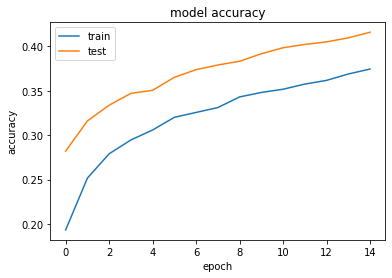

In [65]:
plt.plot(history_resnet2.history['accuracy'])
plt.plot(history_resnet2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
history_resnet2_2=model_resnet2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
990/990 [==============================] - 462s 467ms/step - loss: 1.8562 - accuracy: 0.3832 - val_loss: 1.7697 - val_accuracy: 0.4222
Epoch 2/15
990/990 [==============================] - 475s 480ms/step - loss: 1.8352 - accuracy: 0.3890 - val_loss: 1.7562 - val_accuracy: 0.4309
Epoch 3/15
990/990 [==============================] - 440s 445ms/step - loss: 1.8223 - accuracy: 0.3898 - val_loss: 1.7456 - val_accuracy: 0.4365
Epoch 4/15
990/990 [==============================] - 428s 433ms/step - loss: 1.8097 - accuracy: 0.3952 - val_loss: 1.7191 - val_accuracy: 0.4420
Epoch 5/15
990/990 [==============================] - 435s 440ms/step - loss: 1.7836 - accuracy: 0.4039 - val_loss: 1.7037 - val_accuracy: 0.4485
Epoch 6/15
990/990 [==============================] - 428s 432ms/step - loss: 1.7699 - accuracy: 0.4093 - val_loss: 1.6856 - val_accuracy: 0.4569
Epoch 7/15
990/990 [==============================] - 434s 439ms/step - loss: 1.7608 - accuracy: 0.4123 - val_loss: 1.6733 -

New train round of 15 epochs 

In [67]:
model_resnet2.save("resnet2_30.h5")

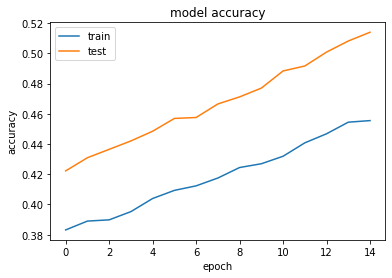

In [68]:
plt.plot(history_resnet2_2.history['accuracy'])
plt.plot(history_resnet2_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
history_resnet2_3=model_resnet2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
990/990 [==============================] - 437s 441ms/step - loss: 1.5937 - accuracy: 0.4633 - val_loss: 1.5186 - val_accuracy: 0.5199
Epoch 2/15
990/990 [==============================] - 432s 437ms/step - loss: 1.5860 - accuracy: 0.4669 - val_loss: 1.5040 - val_accuracy: 0.5250
Epoch 3/15
990/990 [==============================] - 429s 434ms/step - loss: 1.5567 - accuracy: 0.4783 - val_loss: 1.4866 - val_accuracy: 0.5360
Epoch 4/15
990/990 [==============================] - 436s 440ms/step - loss: 1.5413 - accuracy: 0.4791 - val_loss: 1.4666 - val_accuracy: 0.5446
Epoch 5/15
990/990 [==============================] - 439s 444ms/step - loss: 1.5305 - accuracy: 0.4840 - val_loss: 1.4536 - val_accuracy: 0.5417
Epoch 6/15
990/990 [==============================] - 437s 441ms/step - loss: 1.5123 - accuracy: 0.4934 - val_loss: 1.4365 - val_accuracy: 0.5547
Epoch 7/15
990/990 [==============================] - 441s 445ms/step - loss: 1.4886 - accuracy: 0.4987 - val_loss: 1.4220 -

In [70]:
model_resnet2.save("resnet2_45.h5")

In [71]:
history_resnet2_4=model_resnet2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
990/990 [==============================] - 475s 480ms/step - loss: 1.3462 - accuracy: 0.5430 - val_loss: 1.3011 - val_accuracy: 0.6097
Epoch 2/15
990/990 [==============================] - 471s 476ms/step - loss: 1.3312 - accuracy: 0.5474 - val_loss: 1.2871 - val_accuracy: 0.6159
Epoch 3/15
990/990 [==============================] - 470s 475ms/step - loss: 1.3177 - accuracy: 0.5511 - val_loss: 1.2929 - val_accuracy: 0.6085
Epoch 4/15
990/990 [==============================] - 475s 480ms/step - loss: 1.2963 - accuracy: 0.5574 - val_loss: 1.2612 - val_accuracy: 0.6298
Epoch 5/15
990/990 [==============================] - 469s 474ms/step - loss: 1.2773 - accuracy: 0.5674 - val_loss: 1.2598 - val_accuracy: 0.6303
Epoch 6/15
990/990 [==============================] - 475s 480ms/step - loss: 1.2688 - accuracy: 0.5688 - val_loss: 1.2478 - val_accuracy: 0.6338
Epoch 7/15
990/990 [==============================] - 472s 477ms/step - loss: 1.2582 - accuracy: 0.5713 - val_loss: 1.2438 -

In [72]:
model_resnet2.save("resnet2_60.h5")

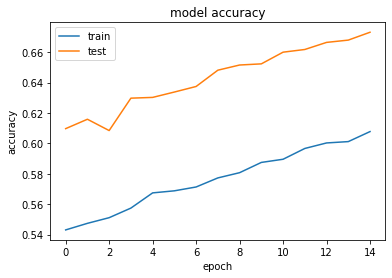

In [73]:
plt.plot(history_resnet2_4.history['accuracy'])
plt.plot(history_resnet2_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
history_resnet2_5=model_resnet2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
990/990 [==============================] - 474s 479ms/step - loss: 1.1369 - accuracy: 0.6102 - val_loss: 1.1668 - val_accuracy: 0.6786
Epoch 2/15
990/990 [==============================] - 478s 483ms/step - loss: 1.1166 - accuracy: 0.6170 - val_loss: 1.1613 - val_accuracy: 0.6751
Epoch 3/15
990/990 [==============================] - 467s 471ms/step - loss: 1.1124 - accuracy: 0.6180 - val_loss: 1.1479 - val_accuracy: 0.6824
Epoch 4/15
990/990 [==============================] - 471s 476ms/step - loss: 1.1023 - accuracy: 0.6239 - val_loss: 1.1382 - val_accuracy: 0.6877
Epoch 5/15
990/990 [==============================] - 465s 470ms/step - loss: 1.0879 - accuracy: 0.6299 - val_loss: 1.1467 - val_accuracy: 0.6916
Epoch 6/15
990/990 [==============================] - 468s 472ms/step - loss: 1.0834 - accuracy: 0.6298 - val_loss: 1.1400 - val_accuracy: 0.6844
Epoch 7/15
990/990 [==============================] - 465s 470ms/step - loss: 1.0678 - accuracy: 0.6333 - val_loss: 1.1461 -

In [87]:
hresnet_a= history_resnet2.history["accuracy"]+history_resnet2_2.history["accuracy"]+history_resnet2_3.history["accuracy"]+history_resnet2_4.history["accuracy"]+history_resnet2_5.history["accuracy"]

In [88]:
hresnet_v= history_resnet2.history["val_accuracy"]+history_resnet2_2.history["val_accuracy"]+history_resnet2_3.history["val_accuracy"]+history_resnet2_4.history["val_accuracy"]+history_resnet2_5.history["val_accuracy"]

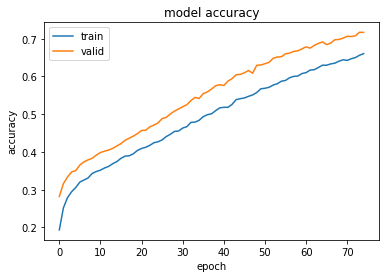

In [90]:
plt.plot(hresnet_a)
plt.plot(hresnet_v)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [76]:
model_resnet2.save("resnet2_75.h5")

In [77]:
predictions = model_resnet2.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)
vclasses = list()
vclasses = [[c.numpy() for c in object[1]]for object in test_ds]
validation_classes = np.concatenate(vclasses).ravel()
[[class_names[a],class_names[b]] for a,b in zip(predicted_classes,validation_classes)][0:30]


[['Romance', 'Young Adult'],
 ['Young Adult', 'Fantasy'],
 ['Poetry', 'Poetry'],
 ['Mystery & Crime', 'Mystery & Crime'],
 ['Fantasy', 'Fantasy'],
 ['Historical', 'Politics & History'],
 ['Sequential Art', 'Sequential Art'],
 ['Young Adult', 'Young Adult'],
 ['Horror', 'Horror'],
 ['Mystery & Crime', 'Fantasy'],
 ['Horror', 'Horror'],
 ['Romance', 'Young Adult'],
 ['Fantasy', 'Fantasy'],
 ['Fantasy', 'Fantasy'],
 ['Fantasy', 'Fantasy'],
 ['Sequential Art', 'Biography'],
 ['Religion & Philosophy', 'Horror'],
 ['Poetry', 'Poetry'],
 ['Fantasy', 'Fantasy'],
 ['Young Adult', 'Young Adult'],
 ['Fantasy', 'Fantasy'],
 ['Romance', 'Romance'],
 ['Politics & History', 'Politics & History'],
 ['Childrens', 'Childrens'],
 ['Romance', 'Romance'],
 ['Religion & Philosophy', 'Religion & Philosophy'],
 ['Politics & History', 'Politics & History'],
 ['Mystery & Crime', 'Mystery & Crime'],
 ['Religion & Philosophy', 'Religion & Philosophy'],
 ['Politics & History', 'Politics & History']]

In [78]:
from sklearn.metrics import classification_report
print(classification_report(validation_classes, predicted_classes, target_names=class_names))

                       precision    recall  f1-score   support

            Biography       0.71      0.55      0.62       171
            Childrens       0.72      0.71      0.71       139
              Fantasy       0.72      0.81      0.76       749
           Historical       0.68      0.68      0.68       381
               Horror       0.64      0.43      0.52       113
      Mystery & Crime       0.61      0.75      0.67       340
               Poetry       0.79      0.57      0.66        96
   Politics & History       0.65      0.61      0.62       190
Religion & Philosophy       0.67      0.63      0.65       263
              Romance       0.75      0.78      0.77       560
      Science Fiction       0.82      0.55      0.66       222
       Sequential Art       0.77      0.85      0.81       136
          Young Adult       0.77      0.74      0.75       389

             accuracy                           0.71      3749
            macro avg       0.71      0.67      0.68 

In [95]:
from tensorflow.keras import layers
from sklearn.utils import class_weight
model_resnet_ld = tf.keras.models.load_model("resnet2_75.h5",custom_objects={'KerasLayer':hub.KerasLayer})

In [96]:
history_resnet2_ld=model_resnet_ld.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25
)

Epoch 1/25
990/990 [==============================] - 473s 475ms/step - loss: 0.9817 - accuracy: 0.6611 - val_loss: 1.1065 - val_accuracy: 0.7196
Epoch 2/25
990/990 [==============================] - 472s 477ms/step - loss: 0.9671 - accuracy: 0.6674 - val_loss: 1.1002 - val_accuracy: 0.7181
Epoch 3/25
990/990 [==============================] - 469s 474ms/step - loss: 0.9551 - accuracy: 0.6692 - val_loss: 1.1066 - val_accuracy: 0.7195
Epoch 4/25
990/990 [==============================] - 473s 478ms/step - loss: 0.9659 - accuracy: 0.6647 - val_loss: 1.1025 - val_accuracy: 0.7213
Epoch 5/25
990/990 [==============================] - 473s 478ms/step - loss: 0.9414 - accuracy: 0.6758 - val_loss: 1.0872 - val_accuracy: 0.7252
Epoch 6/25
990/990 [==============================] - 468s 473ms/step - loss: 0.9481 - accuracy: 0.6712 - val_loss: 1.0983 - val_accuracy: 0.7240
Epoch 7/25
990/990 [==============================] - 472s 477ms/step - loss: 0.9252 - accuracy: 0.6822 - val_loss: 1.0867 -

In [98]:
model_resnet_ld.save("resnet2_100.h5")

In [145]:
predictions = model_resnet_ld.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)
vclasses = list()
vclasses = [[c.numpy() for c in object[1]]for object in val_ds]
validation_classes = np.concatenate(vclasses).ravel()

In [146]:
print(classification_report(validation_classes, predicted_classes, target_names=class_names))

                       precision    recall  f1-score   support

            Biography       0.66      0.69      0.67       363
            Childrens       0.75      0.75      0.75       300
              Fantasy       0.76      0.86      0.81      1576
           Historical       0.77      0.71      0.74       814
               Horror       0.85      0.55      0.66       238
      Mystery & Crime       0.68      0.76      0.72       721
               Poetry       0.80      0.65      0.72       198
   Politics & History       0.69      0.68      0.69       402
Religion & Philosophy       0.75      0.67      0.70       552
              Romance       0.75      0.84      0.79      1183
      Science Fiction       0.85      0.64      0.73       468
       Sequential Art       0.82      0.82      0.82       288
          Young Adult       0.81      0.75      0.78       823

             accuracy                           0.76      7926
            macro avg       0.76      0.72      0.74 

VGG16 model

In [158]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

In [154]:
modelVGG = VGG16(include_top=False, input_shape=(150, 100, 3),weights="imagenet",classes=13)

58892288/58889256 [==============================] - 10s 0us/step


In [155]:
for layer in modelVGG.layers:
   layer.trainable = False


In [159]:

x=Flatten()(modelVGG.output)
prediction=Dense(13,activation='softmax')(x)
model_v=Model(inputs=modelVGG.input,outputs=prediction)

In [177]:
num_classes=13

x=Flatten()(modelVGG.output)
outs = Dense(256,activation='relu')(x)
model_v2=Model(inputs=modelVGG.input,outputs=outs)

model_VGG2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  model_v2,
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
   layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model_VGG.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [178]:
history_VGG=model_VGG.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
1085/1085 [==============================] - 1106s 1s/step - loss: 2.4130 - accuracy: 0.2142 - val_loss: 2.2174 - val_accuracy: 0.2670
Epoch 2/10
1085/1085 [==============================] - 1046s 964ms/step - loss: 2.2389 - accuracy: 0.2553 - val_loss: 2.1629 - val_accuracy: 0.2815
Epoch 3/10
1085/1085 [==============================] - 1050s 968ms/step - loss: 2.2203 - accuracy: 0.2597 - val_loss: 2.1411 - val_accuracy: 0.2892
Epoch 4/10
1085/1085 [==============================] - 1051s 969ms/step - loss: 2.1985 - accuracy: 0.2695 - val_loss: 2.1494 - val_accuracy: 0.2847
Epoch 5/10
1085/1085 [==============================] - 1063s 980ms/step - loss: 2.2006 - accuracy: 0.2652 - val_loss: 2.1156 - val_accuracy: 0.2976
Epoch 6/10
 230/1085 [=====>........................] - ETA: 13:39 - loss: 2.1653 - accuracy: 0.2774

KeyboardInterrupt: 